# Hastings Direct DS Interview

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lightgbm import LGBMRegressor
import lightgbm as lgb

pd.set_option('display.max_columns', None)

### Data Cleaning

In [760]:
df = pd.read_csv('/Users/jeannietan/BWQDrive/Documents/Professional/Job Hunting Graduate/Hastings Direct Junior DS/Data_Scientist_Interview_Task_Original(Data).csv', encoding="cp1252")
df.head()

,Claim Number,date_of_loss,Notifier,Loss_code,Loss_description,Notification_period,Inception_to_loss,Location_of_incident,Weather_conditions,Vehicle_mobile,Time_hour,Main_driver,PH_considered_TP_at_fault,Vechile_registration_present,Incident_details_present,Injury_details_present,TP_type_insd_pass_back,TP_type_insd_pass_front,TP_type_driver,TP_type_pass_back,TP_type_pass_front,TP_type_bike,TP_type_cyclist,TP_type_pass_multi,TP_type_pedestrian,TP_type_other,TP_type_nk,TP_injury_whiplash,TP_injury_traumatic,TP_injury_fatality,TP_injury_unclear,TP_injury_nk,TP_region_eastang,TP_region_eastmid,TP_region_london,TP_region_north,TP_region_northw,TP_region_outerldn,TP_region_scotland,TP_region_southe,TP_region_southw,TP_region_wales,TP_region_westmid,TP_region_yorkshire,Incurred,Capped Incurred,Unnamed: 46
0,1,2003-04-15,PH,LD003,Head on collision,22,13,Main Road,NORMAL,Y,10,Other,n/k,1,-,-,-,-,-,-,-,-,-,-,-,-,1,-,-,-,1,-,-,-,-,-,1,-,-,-,-,-,-,-,£-,£-,NaN
1,2,2003-04-20,CNF,LD003,Head on collision,1,9,Main Road,WET,Y,18,Other,n/k,1,1,-,-,-,-,-,-,-,-,-,-,-,1,-,-,-,1,-,-,-,-,-,-,-,-,1,-,-,-,-,"£2,801","£2,801",NaN
2,3,2003-04-24,CNF,LD003,Head on collision,5,17,Main Road,WET,Y,16,Y,n/k,1,-,-,-,-,-,-,-,-,-,-,-,-,1,-,-,-,1,-,-,-,-,-,1,-,-,-,-,-,-,-,"£1,221","£1,221",NaN
3,4,2003-05-13,CNF,LD003,Head on collision,1,23,Main Road,N/K,Y,14,Other,n/k,1,1,-,-,-,-,-,-,-,-,-,-,-,1,-,-,-,1,-,-,-,-,-,-,-,-,-,-,-,1,-,"£3,530","£3,530",NaN
4,5,2003-06-11,CNF,LD003,Head on collision,1,48,Other,N/K,N,9,Other,n/k,1,1,-,-,-,-,-,-,-,-,-,-,-,1,-,-,-,1,1,-,-,-,-,-,-,-,-,-,-,-,-,"£3,156","£3,156",NaN


In [466]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Claim Number,7691.0,3846.000000,2220.344793,1.0,1923.5,3846.0,5768.5,7691.0
Notification_period,7691.0,7.163438,39.138209,-18.0,0.0,1.0,2.0,1042.0
Inception_to_loss,7691.0,166.854505,104.452906,0.0,75.0,161.0,253.0,365.0
Time_hour,7691.0,12.729684,5.107136,0.0,9.0,13.0,17.0,23.0
Unnamed: 46,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [761]:
df.columns = df.columns.str.strip() #removing leading and trailing spaces in col names
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

df.drop(columns = 'Unnamed: 46', inplace=True)

/var/folders/1b/py3yqqc57d5dfrwhf8h9rb540000gn/T/ipykernel_41970/1997217529.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [ ]:
# print(df['Injury_details_present'].value_counts().sort_index())

columns = ['Notifier', 'Loss_code', 'Loss_description','Location_of_incident', 
        'Weather_conditions', 'Vehicle_mobile','Main_driver', 'PH_considered_TP_at_fault',
       'Vechile_registration_present', 'Incident_details_present',
       'Injury_details_present', 'TP_type_insd_pass_back',
       'TP_type_insd_pass_front', 'TP_type_driver', 'TP_type_pass_back',
       'TP_type_pass_front', 'TP_type_bike', 'TP_type_cyclist',
       'TP_type_pass_multi', 'TP_type_pedestrian', 'TP_type_other',
       'TP_type_nk', 'TP_injury_whiplash', 'TP_injury_traumatic',
       'TP_injury_fatality', 'TP_injury_unclear', 'TP_injury_nk',
       'TP_region_eastang', 'TP_region_eastmid', 'TP_region_london',
       'TP_region_north', 'TP_region_northw', 'TP_region_outerldn',
       'TP_region_scotland', 'TP_region_southe', 'TP_region_southw',
       'TP_region_wales', 'TP_region_westmid', 'TP_region_yorkshire']

for i in columns: # pulling counts of distinct values in columns
    print(df[i].value_counts().sort_index())
    print()


Notifier
CNF             262
NamedDriver     180
Other          3117
PH             3807
TP              325
Name: count, dtype: int64

Loss_code
LD003    7691
Name: count, dtype: int64

Loss_description
Head on collision    7691
Name: count, dtype: int64

Location_of_incident
Car Park           225
Home Address       104
Main Road         2702
Minor Road        4249
Motorway            25
Not Applicable      56
Other              117
n/k                213
Name: count, dtype: int64

Weather_conditions
N/K              450
NORMAL          4564
SNOW,ICE,FOG     429
WET             1903
Name: count, dtype: int64

Vehicle_mobile
N      3203
Y      4046
n/k     442
Name: count, dtype: int64

Main_driver
N         432
Other    2940
Y        4319
Name: count, dtype: int64

PH_considered_TP_at_fault
#         1
N      4855
Y       181
n/k    2654
Name: count, dtype: int64

Vechile_registration_present
-       6
1    7685
Name: count, dtype: int64

Incident_details_present
-    1474
1    6217


In [762]:
df.drop(columns = ['Loss_code','Loss_description','TP_type_insd_pass_front', 'TP_type_pass_multi', 'Incurred'], inplace=True)

# reformatting
df["Capped Incurred"] = df["Capped Incurred"].str.replace("£", "").str.replace(",", "").str.replace("-","-1").astype(int)
df["Vechile_registration_present"] = df["Vechile_registration_present"].str.replace("-", "0").astype(int)
df["Incident_details_present"] = df["Incident_details_present"].str.replace("-", "0").astype(int)
df["Injury_details_present"] = df["Injury_details_present"].str.replace("-", "0").astype(int)

# filling missing/negative values with mean
df["Capped Incurred"] = df["Capped Incurred"].mask(df["Capped Incurred"] < 0, df["Capped Incurred"].mean()).astype(int)
df["Notification_period"] = df["Notification_period"].mask(df["Notification_period"] < 0, df["Notification_period"].mean()).astype(int)

cols=['TP_type_insd_pass_back',
      'TP_type_driver', 'TP_type_pass_back', 'TP_type_pass_front', 'TP_type_bike', 'TP_type_cyclist',
       'TP_type_pedestrian', 'TP_type_other',
       'TP_type_nk', 'TP_injury_whiplash', 'TP_injury_traumatic',
       'TP_injury_fatality', 'TP_injury_unclear', 'TP_injury_nk',
       'TP_region_eastang', 'TP_region_eastmid', 'TP_region_london',
       'TP_region_north', 'TP_region_northw', 'TP_region_outerldn',
       'TP_region_scotland', 'TP_region_southe', 'TP_region_southw',
       'TP_region_wales', 'TP_region_westmid', 'TP_region_yorkshire']

df[cols] = df[cols].replace('-', 0).fillna(0).astype(int)

df['date_of_loss'] = pd.to_datetime(df['date_of_loss'])

df.head()

,Claim Number,date_of_loss,Notifier,Notification_period,Inception_to_loss,Location_of_incident,Weather_conditions,Vehicle_mobile,Time_hour,Main_driver,PH_considered_TP_at_fault,Vechile_registration_present,Incident_details_present,Injury_details_present,TP_type_insd_pass_back,TP_type_driver,TP_type_pass_back,TP_type_pass_front,TP_type_bike,TP_type_cyclist,TP_type_pedestrian,TP_type_other,TP_type_nk,TP_injury_whiplash,TP_injury_traumatic,TP_injury_fatality,TP_injury_unclear,TP_injury_nk,TP_region_eastang,TP_region_eastmid,TP_region_london,TP_region_north,TP_region_northw,TP_region_outerldn,TP_region_scotland,TP_region_southe,TP_region_southw,TP_region_wales,TP_region_westmid,TP_region_yorkshire,Capped Incurred
0,1,2003-04-15,PH,22,13,Main Road,NORMAL,Y,10,Other,n/k,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,6080
1,2,2003-04-20,CNF,1,9,Main Road,WET,Y,18,Other,n/k,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,2801
2,3,2003-04-24,CNF,5,17,Main Road,WET,Y,16,Y,n/k,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1221
3,4,2003-05-13,CNF,1,23,Main Road,N/K,Y,14,Other,n/k,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3530
4,5,2003-06-11,CNF,1,48,Other,N/K,N,9,Other,n/k,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3156


In [629]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7691 entries, 0 to 7690
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Claim Number                  7691 non-null   int64         
 1   date_of_loss                  7691 non-null   datetime64[ns]
 2   Notifier                      7691 non-null   object        
 3   Notification_period           7691 non-null   int64         
 4   Inception_to_loss             7691 non-null   int64         
 5   Location_of_incident          7691 non-null   object        
 6   Weather_conditions            7346 non-null   object        
 7   Vehicle_mobile                7691 non-null   object        
 8   Time_hour                     7691 non-null   int64         
 9   Main_driver                   7691 non-null   object        
 10  PH_considered_TP_at_fault     7691 non-null   object        
 11  Vechile_registration_present  

In [763]:
# merging columns
df["TP_injury_nk"] = df["TP_injury_unclear"] + df["TP_injury_nk"]
df = df.drop(columns=["TP_injury_unclear"])

df["TP_type_other"] = df["TP_type_other"] + df["TP_type_pedestrian"]
df = df.drop(columns=["TP_type_pedestrian"])

In [764]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Claim Number,7691.0,3846.0,1.0,1923.5,3846.0,5768.5,7691.0,2220.344793
date_of_loss,7691,2011-07-13 01:15:38.499544832,2003-04-15 00:00:00,2009-01-21 00:00:00,2012-07-10 00:00:00,2014-05-19 00:00:00,2015-06-30 00:00:00,NaN
Notification_period,7691.0,7.168899,0.0,0.0,1.0,2.0,1042.0,39.136907
Inception_to_loss,7691.0,166.854505,0.0,75.0,161.0,253.0,365.0,104.452906
Time_hour,7691.0,12.729684,0.0,9.0,13.0,17.0,23.0,5.107136
Vechile_registration_present,7691.0,0.99922,0.0,1.0,1.0,1.0,1.0,0.027922
Incident_details_present,7691.0,0.808347,0.0,1.0,1.0,1.0,1.0,0.393627
Injury_details_present,7691.0,0.232089,0.0,0.0,0.0,0.0,1.0,0.422193
TP_type_insd_pass_back,7691.0,0.028995,0.0,0.0,0.0,0.0,4.0,0.219508
TP_type_driver,7691.0,0.651671,0.0,0.0,1.0,1.0,5.0,0.544726


In [765]:
# capping at 99th percentile
percentile99 = df['Notification_period'].quantile(0.99)
df['Notification_period'] = df['Notification_period'].clip(lower=None, upper=percentile99).astype(int)

In [766]:
df_cleaned = df.copy()

## Feature Engineering 

In [767]:
df['loss_year'] = df['date_of_loss'].dt.year
df['loss_month'] = df['date_of_loss'].dt.month
df['loss_day'] = df['date_of_loss'].dt.dayofweek

df['loss_spring'] = ((df['loss_month']>=3) & (df['loss_month']<=5)).astype(int)
df['loss_summer'] = ((df['loss_month']>=6) & (df['loss_month']<=8)).astype(int)
df['loss_autumn'] = ((df['loss_month']>=9) & (df['loss_month']<=11)).astype(int)
df['loss_winter'] = ((df['loss_month']==12) | (df['loss_month']<=2)).astype(int)
df['loss_weekend'] = ((df['loss_day']>=5)).astype(int)

df = df.drop(columns=['date_of_loss'])

df.head()

,Claim Number,Notifier,Notification_period,Inception_to_loss,Location_of_incident,Weather_conditions,Vehicle_mobile,Time_hour,Main_driver,PH_considered_TP_at_fault,Vechile_registration_present,Incident_details_present,Injury_details_present,TP_type_insd_pass_back,TP_type_driver,TP_type_pass_back,TP_type_pass_front,TP_type_bike,TP_type_cyclist,TP_type_other,TP_type_nk,TP_injury_whiplash,TP_injury_traumatic,TP_injury_fatality,TP_injury_nk,TP_region_eastang,TP_region_eastmid,TP_region_london,TP_region_north,TP_region_northw,TP_region_outerldn,TP_region_scotland,TP_region_southe,TP_region_southw,TP_region_wales,TP_region_westmid,TP_region_yorkshire,Capped Incurred,loss_year,loss_month,loss_day,loss_spring,loss_summer,loss_autumn,loss_winter,loss_weekend
0,1,PH,22,13,Main Road,NORMAL,Y,10,Other,n/k,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,6080,2003,4,1,1,0,0,0,0
1,2,CNF,1,9,Main Road,WET,Y,18,Other,n/k,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,2801,2003,4,6,1,0,0,0,1
2,3,CNF,5,17,Main Road,WET,Y,16,Y,n/k,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1221,2003,4,3,1,0,0,0,0
3,4,CNF,1,23,Main Road,N/K,Y,14,Other,n/k,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,3530,2003,5,1,1,0,0,0,0
4,5,CNF,1,48,Other,N/K,N,9,Other,n/k,1,1,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,3156,2003,6,2,0,1,0,0,0


In [768]:
df['Time_hour'] = df['Time_hour'].astype(int)

df['time_early_am'] = ((df['Time_hour']>=1) & (df['Time_hour']<=5)).astype(int)
df['time_am'] = ((df['Time_hour']>=6) & (df['Time_hour']<=9)).astype(int)
df['time_late_am'] = ((df['Time_hour']>=10) & (df['Time_hour']<=11)).astype(int)
df['time_early_pm'] = ((df['Time_hour']>=12) & (df['Time_hour']<=14)).astype(int)
df['time_rush_hour'] = ((df['Time_hour']>=15) & (df['Time_hour']<=18)).astype(int)
df['time_eve'] = ((df['Time_hour']>=19) & (df['Time_hour']<=21)).astype(int)
df['time_night'] = ((df['Time_hour']>=22) | (df['Time_hour']==0)).astype(int)

In [769]:
# one-hot encoding
categorical_columns = ['Notifier', 'Location_of_incident', 'Weather_conditions', 'Vehicle_mobile', 'Main_driver', 'PH_considered_TP_at_fault']

df = pd.get_dummies(data = df, columns=categorical_columns, dtype=int)
df.head()

,Claim Number,Notification_period,Inception_to_loss,Time_hour,Vechile_registration_present,Incident_details_present,Injury_details_present,TP_type_insd_pass_back,TP_type_driver,TP_type_pass_back,TP_type_pass_front,TP_type_bike,TP_type_cyclist,TP_type_other,TP_type_nk,TP_injury_whiplash,TP_injury_traumatic,TP_injury_fatality,TP_injury_nk,TP_region_eastang,TP_region_eastmid,TP_region_london,TP_region_north,TP_region_northw,TP_region_outerldn,TP_region_scotland,TP_region_southe,TP_region_southw,TP_region_wales,TP_region_westmid,TP_region_yorkshire,Capped Incurred,loss_year,loss_month,loss_day,loss_spring,loss_summer,loss_autumn,loss_winter,loss_weekend,time_early_am,time_am,time_late_am,time_early_pm,time_rush_hour,time_eve,time_night,Notifier_CNF,Notifier_NamedDriver,Notifier_Other,Notifier_PH,Notifier_TP,Location_of_incident_Car Park,Location_of_incident_Home Address,Location_of_incident_Main Road,Location_of_incident_Minor Road,Location_of_incident_Motorway,Location_of_incident_Not Applicable,Location_of_incident_Other,Location_of_incident_n/k,Weather_conditions_N/K,Weather_conditions_NORMAL,"Weather_conditions_SNOW,ICE,FOG",Weather_conditions_WET,Vehicle_mobile_N,Vehicle_mobile_Y,Vehicle_mobile_n/k,Main_driver_N,Main_driver_Other,Main_driver_Y,PH_considered_TP_at_fault_#,PH_considered_TP_at_fault_N,PH_considered_TP_at_fault_Y,PH_considered_TP_at_fault_n/k
0,1,22,13,10,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,6080,2003,4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
1,2,1,9,18,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,2801,2003,4,6,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1
2,3,5,17,16,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1221,2003,4,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1
3,4,1,23,14,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,3530,2003,5,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1
4,5,1,48,9,1,1,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,3156,2003,6,2,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1


In [770]:
# for lightgbm removing JSON
df.columns = df.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)

In [771]:
df_final=df.copy()

In [759]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7691 entries, 0 to 7690
Data columns (total 74 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   Claim_Number                         7691 non-null   int64
 1   Notification_period                  7691 non-null   int64
 2   Inception_to_loss                    7691 non-null   int64
 3   Time_hour                            7691 non-null   int64
 4   Vechile_registration_present         7691 non-null   int64
 5   Incident_details_present             7691 non-null   int64
 6   Injury_details_present               7691 non-null   int64
 7   TP_type_insd_pass_back               7691 non-null   int64
 8   TP_type_driver                       7691 non-null   int64
 9   TP_type_pass_back                    7691 non-null   int64
 10  TP_type_pass_front                   7691 non-null   int64
 11  TP_type_bike                         7691 non-null   int

## Model Training

In [772]:
df_claim_number = df.pop('Claim_Number') #separate out claim number to be joined back on later

In [773]:
y = df.pop('Capped_Incurred') # move target variable into y
x = df.copy()

In [774]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

#### Correlation Matrix

In [775]:
corr_matrix = x.corr()

high_corr_features = [(col1, col2, corr_matrix.loc[col1, col2])
                     for col1 in corr_matrix.columns
                     for col2 in corr_matrix.columns
                     if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > 0.8]

coll_df = pd.DataFrame(high_corr_features, columns=["Feature 1", "Feature 2", "Correlation"])

vif = pd.DataFrame()
vif["Feature"] = x.columns
vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

print(coll_df)
print(vif)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                          Feature 1                        Feature 2  \
0                         loss_year      PH_considered_TP_at_fault_N   
1                         loss_year    PH_considered_TP_at_fault_n_k   
2                    Notifier_Other                      Notifier_PH   
3                       Notifier_PH                   Notifier_Other   
4    Location_of_incident_Main_Road  Location_of_incident_Minor_Road   
5   Location_of_incident_Minor_Road   Location_of_incident_Main_Road   
6                  Vehicle_mobile_N                 Vehicle_mobile_Y   
7                  Vehicle_mobile_Y                 Vehicle_mobile_N   
8                 Main_driver_Other                    Main_driver_Y   
9                     Main_driver_Y                Main_driver_Other   
10      PH_considered_TP_at_fault_N                        loss_year   
11      PH_considered_TP_at_fault_N    PH_considered_TP_at_fault_n_k   
12    PH_considered_TP_at_fault_n_k                        loss_

### Random Forest

#### Untuned

In [ ]:
model_rf = RandomForestRegressor(random_state=1).fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
y_pred_train_rf = model_rf.predict(X_train)

print(mean_absolute_error(y_test, y_pred_rf),np.sqrt(mean_squared_error(y_test, y_pred_rf)), r2_score(y_test, y_pred_rf))
print(mean_absolute_error(y_train, y_pred_train_rf),np.sqrt(mean_squared_error(y_train, y_pred_train_rf)), r2_score(y_train, y_pred_train_rf))

5010.252755035737 8235.010073615238 0.4101498882444641
1911.2180591677504 3096.9660785643086 0.9131987518613182


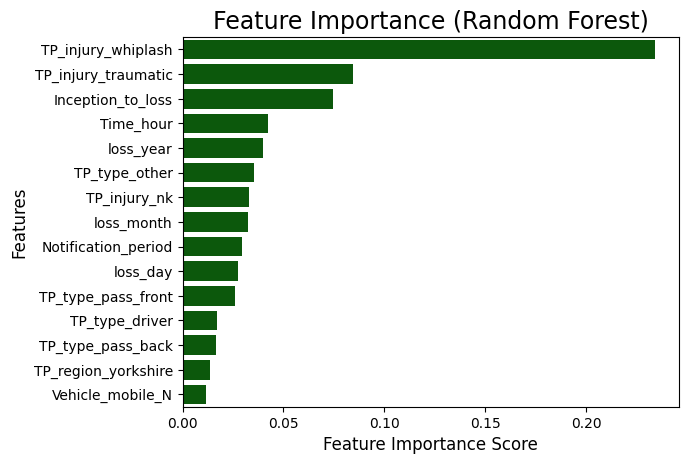

In [ ]:
feature_scores = pd.Series(model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_scores[:15], y=feature_scores.index[:15], color = 'darkgreen')

plt.xlabel('Feature Importance Score', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Features', fontsize=12)
plt.yticks(fontsize=10)
plt.title("Feature Importance (Random Forest)", fontsize=17)
plt.show()

#### Tuned

In [ ]:
# hyperparameter tuning with Optuna
def objective(trial):
    params = {
        "random_state": 1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }

    model_rf = RandomForestRegressor(**params)

    score = cross_val_score(
        model_rf,
        X_train,
        y_train,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    ).mean()

    return score

study = optuna.create_study(direction="maximize")  # max -MAE
study.optimize(objective, n_trials=20, show_progress_bar=True)

In [670]:
print("Best trial:")
print(study.best_trial.params)

Best trial:
{'n_estimators': 1348, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}


In [678]:
best_params = study.best_trial.params

model_rf = RandomForestRegressor(random_state=1, **best_params).fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
y_pred_train_rf = model_rf.predict(X_train)

print(mean_absolute_error(y_test, y_pred_rf),np.sqrt(mean_squared_error(y_test, y_pred_rf)), r2_score(y_test, y_pred_rf))
print(mean_absolute_error(y_train, y_pred_train_rf),np.sqrt(mean_squared_error(y_train, y_pred_train_rf)), r2_score(y_train, y_pred_train_rf))

4876.57095722139 8008.650294165337 0.44213122106916525
3376.3319777895495 4891.686695342626 0.7834439407408986


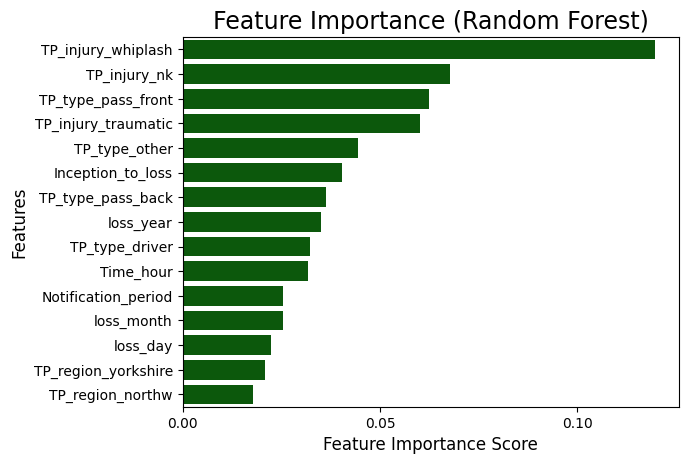

In [ ]:
feature_scores = pd.Series(model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_scores[:15], y=feature_scores.index[:15], color = 'darkgreen')

plt.xlabel('Feature Importance Score', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Features', fontsize=12)
plt.yticks(fontsize=10)
plt.title("Feature Importance (Random Forest)", fontsize=17)
plt.show()

### Light GBM

#### Untuned

In [ ]:
model_lgbm = LGBMRegressor(random_state=1).fit(X_train, y_train)
 
y_pred_lgbm = model_lgbm.predict(X_test)
y_pred_train_lgbm = model_lgbm.predict(X_train)

print(mean_absolute_error(y_test, y_pred_lgbm),np.sqrt(mean_squared_error(y_test, y_pred_lgbm)), r2_score(y_test, y_pred_lgbm))
print(mean_absolute_error(y_train, y_pred_train_lgbm),np.sqrt(mean_squared_error(y_train, y_pred_train_lgbm)), r2_score(y_train, y_pred_train_lgbm))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 586
[LightGBM] [Info] Number of data points in the train set: 6152, number of used features: 69
[LightGBM] [Info] Start training from score 7521.805754
4964.388435827533 8094.440045688081 0.4301152731904069
3765.24999059916 5620.955642844864 0.7140610031055965


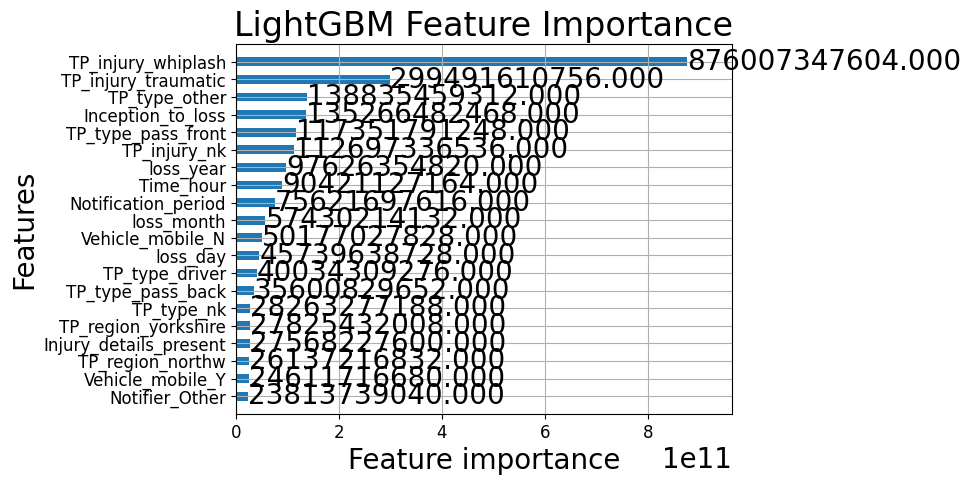

In [624]:
lgb.plot_importance(model_lgbm, max_num_features = 20, importance_type="gain", title="LightGBM Feature Importance", height=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### Tuned

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 1000, step=100),
        "max_bin": trial.suggest_int("max_bin", 350, 450),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 1),
    }
    model = LGBMRegressor(random_state=1,**params)

    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    ).mean()

    return score 

# Run study
study = optuna.create_study(direction="maximize")  # max -MAE
study.optimize(objective, n_trials=20, show_progress_bar=True)

In [ ]:
print("Best trial:")
print(study.best_trial.params)

Best trial:
{'n_estimators': 3000, 'learning_rate': 0.002612836487401132, 'num_leaves': 920, 'max_depth': 6, 'min_data_in_leaf': 50, 'max_bin': 448, 'bagging_fraction': 0.9, 'bagging_freq': 1}


In [ ]:
best_params = study.best_trial.params

model_lgbm = LGBMRegressor(
    random_state=1,
    **best_params
).fit(X_train, y_train)

y_pred_lgbm = model_lgbm.predict(X_test)
y_pred_train_lgbm = model_lgbm.predict(X_train)

print(mean_absolute_error(y_test, y_pred_lgbm),np.sqrt(mean_squared_error(y_test, y_pred_lgbm)), r2_score(y_test, y_pred_lgbm))
print(mean_absolute_error(y_train, y_pred_train_lgbm),np.sqrt(mean_squared_error(y_train, y_pred_train_lgbm)), r2_score(y_train, y_pred_train_lgbm))

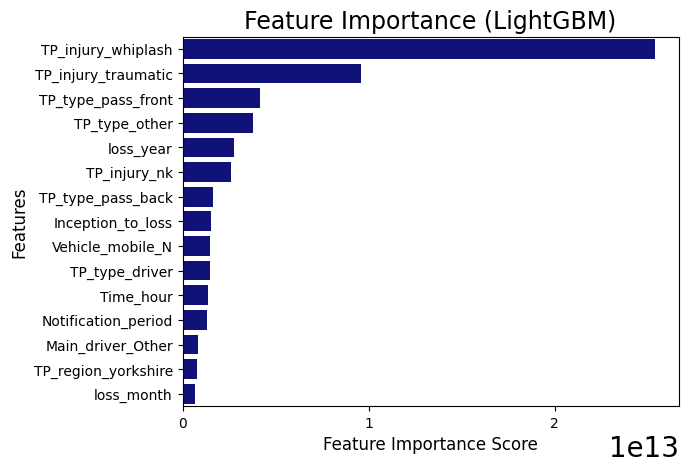

In [698]:
booster = model_lgbm.booster_
importances = booster.feature_importance(importance_type="gain")

feature_scores = pd.DataFrame({
    'Feature': booster.feature_name(),
    'Importance': importances}).sort_values(by='Importance', ascending=False)

sns.barplot(y=feature_scores['Feature'][:15], x=feature_scores['Importance'][:15], color = 'darkblue')
plt.xlabel('Feature Importance Score', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Features', fontsize=12)
plt.yticks(fontsize=10)
plt.title("Feature Importance (LightGBM)", fontsize=17)
plt.show()

### Linear Regression

In [734]:
x_lgr = x.drop(columns=['loss_spring', 'Vehicle_mobile_N', 'Vehicle_mobile_n_k'])

In [ ]:
X_lgr_train, X_lgr_test, y_train, y_test = train_test_split(x_lgr, y, test_size=0.2, random_state=1)

In [740]:
scaler = StandardScaler()
scaler.set_output(transform='pandas')

X_train_scaled, X_test_scaled = scaler.fit_transform(X_lgr_train), scaler.transform(X_lgr_test)

In [741]:
X_train_scaled.head()

,Notification_period,Inception_to_loss,Time_hour,Vechile_registration_present,Incident_details_present,Injury_details_present,TP_type_insd_pass_back,TP_type_driver,TP_type_pass_back,TP_type_pass_front,TP_type_bike,TP_type_cyclist,TP_type_other,TP_type_nk,TP_injury_whiplash,TP_injury_traumatic,TP_injury_fatality,TP_injury_nk,TP_region_eastang,TP_region_eastmid,TP_region_london,TP_region_north,TP_region_northw,TP_region_outerldn,TP_region_scotland,TP_region_southe,TP_region_southw,TP_region_wales,TP_region_westmid,TP_region_yorkshire,loss_year,loss_month,loss_day,loss_summer,loss_autumn,loss_winter,loss_weekend,time_early_am,time_am,time_late_am,time_early_pm,time_rush_hour,time_eve,time_night,Notifier_CNF,Notifier_NamedDriver,Notifier_Other,Notifier_PH,Notifier_TP,Location_of_incident_Car_Park,Location_of_incident_Home_Address,Location_of_incident_Main_Road,Location_of_incident_Minor_Road,Location_of_incident_Motorway,Location_of_incident_Not_Applicable,Location_of_incident_Other,Location_of_incident_n_k,Weather_conditions_N_K,Weather_conditions_NORMAL,Weather_conditions_SNOW_ICE_FOG,Weather_conditions_WET,Vehicle_mobile_Y,Main_driver_N,Main_driver_Other,Main_driver_Y,PH_considered_TP_at_fault__,PH_considered_TP_at_fault_N,PH_considered_TP_at_fault_Y,PH_considered_TP_at_fault_n_k
6947,-0.287516,0.891138,0.849053,0.031245,0.488441,-0.551059,-0.131926,0.637652,-0.153972,-0.236193,-0.081999,-0.025507,-0.214497,-0.669285,-0.409758,-0.241426,-0.058749,0.493986,-0.166278,-0.180877,-0.102852,-0.133704,-0.188116,-0.162087,-0.100479,-0.272452,-0.262482,-0.185694,-0.211474,-0.221252,1.194919,-1.595591,-0.448426,-0.560329,-0.580604,1.683868,-0.556321,-0.123891,-0.548050,-0.34075,-0.474095,1.465747,-0.297753,-0.268609,-0.181883,-0.147503,1.202953,-0.992551,-0.208797,-0.170102,-0.121847,1.357045,-1.108961,-0.059907,-0.084874,-0.129844,-0.164974,-0.251142,0.831288,-0.237316,-0.578101,0.941869,-0.236933,-0.789171,0.880898,-0.01275,0.760691,-0.153712,-0.723030
910,0.035779,-1.301044,-2.499012,0.031245,0.488441,-0.551059,-0.131926,-1.202328,-0.153972,-0.236193,-0.081999,-0.025507,-0.214497,1.252059,-0.409758,-0.241426,-0.058749,-0.508323,-0.166278,-0.180877,-0.102852,-0.133704,-0.188116,-0.162087,-0.100479,-0.272452,2.652297,-0.185694,-0.211474,-0.221252,-1.504729,0.961789,0.071988,-0.560329,1.722345,-0.593871,-0.556321,-0.123891,-0.548050,-0.34075,-0.474095,-0.682246,-0.297753,3.722889,-0.181883,-0.147503,-0.831288,-0.992551,4.789336,-0.170102,-0.121847,-0.736895,0.901745,-0.059907,-0.084874,-0.129844,-0.164974,3.981808,-1.202953,-0.237316,-0.578101,-1.061719,-0.236933,1.267153,-1.135205,-0.01275,-1.314595,-0.153712,1.383069
4224,-0.233633,-0.946848,0.652108,0.031245,0.488441,-0.551059,-0.131926,0.637652,-0.153972,-0.236193,-0.081999,-0.025507,-0.214497,-0.669285,-0.409758,-0.241426,-0.058749,-0.508323,-0.166278,-0.180877,-0.102852,-0.133704,-0.188116,-0.162087,5.418699,-0.272452,-0.262482,-0.185694,-0.211474,-0.221252,0.295036,1.530095,0.071988,-0.560329,-0.580604,1.683868,-0.556321,-0.123891,-0.548050,-0.34075,-0.474095,1.465747,-0.297753,-0.268609,-0.181883,-0.147503,-0.831288,1.007505,-0.208797,-0.170102,-0.121847,1.357045,-1.108961,-0.059907,-0.084874,-0.129844,-0.164974,-0.251142,-1.202953,-0.237316,1.729801,0.941869,-0.236933,-0.789171,0.880898,-0.01275,0.760691,-0.153712,-0.723030
5356,-0.287516,-1.109587,-0.726507,0.031245,0.488441,-0.551059,-0.131926,0.637652,-0.153972,-0.236193,-0.081999,-0.025507,2.528926,-0.669285,-0.409758,-0.241426,-0.058749,2.498604,-0.166278,-0.180877,-0.102852,-0.133704,-0.188116,-0.162087,-0.100479,-0.272452,-0.262482,-0.185694,-0.211474,-0.221252,0.894958,-1.595591,-0.968840,-0.560329,-0.580604,1.683868,-0.556321,-0.123891,1.824649,-0.34075,-0.474095,-0.682246,-0.297753,-0.268609,-0.181883,-0.147503,-0.831288,1.007505,-0.208797,-0.170102,8.207043,-0.736895,-1.108961,-0.059907,-0.084874,-0.129844,-0.164974,-0.251142,-1.202953,4.213798,-0.578101,0.941869,-0.236933,-0.789171,0.880898,-0.01275,0.760691,-0.15371

In [742]:
model_lgr = LinearRegression().fit(X=X_train_scaled, y=y_train)

y_pred_lgr = model_lgr.predict(X=X_test_scaled)
y_pred_train_lgr = model_lgr.predict(X=X_train_scaled)


print(mean_absolute_error(y_test, y_pred_lgr),np.sqrt(mean_squared_error(y_test, y_pred_lgr)), r2_score(y_test, y_pred_lgr))
print(mean_absolute_error(y_train, y_pred_train_lgr),np.sqrt(mean_squared_error(y_train, y_pred_train_lgr)), r2_score(y_train, y_pred_train_lgr))

4942.210213341075 8072.885078235752 0.43314636394559236
5043.417620836885 7946.1554909656625 0.42856453398925975


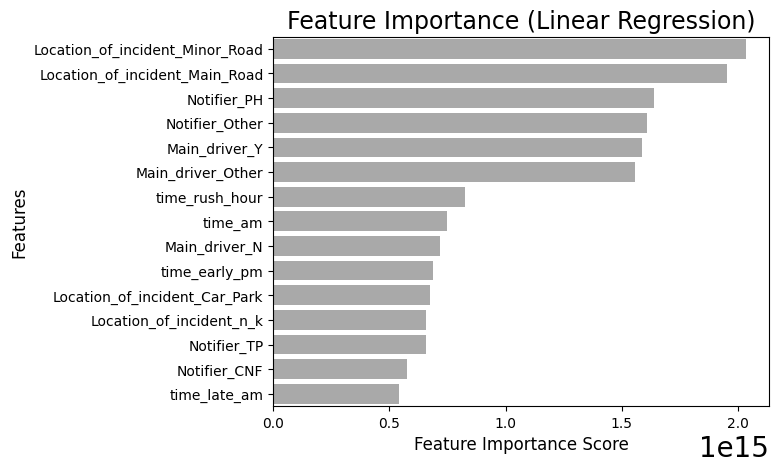

In [745]:
coef_df = pd.DataFrame({"Feature": x_lgr.columns, "Coefficient": model_lgr.coef_})
coef_df["AbsCoeff"] = coef_df["Coefficient"].abs()

coef_df_sorted = coef_df.sort_values(by="AbsCoeff", ascending=False).head(15)

sns.barplot(y=coef_df_sorted['Feature'][:15], x=coef_df_sorted['AbsCoeff'][:15], color = 'darkgrey')

plt.xlabel('Feature Importance Score', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Features', fontsize=12)
plt.yticks(fontsize=10)
plt.title("Feature Importance (Linear Regression)", fontsize=17)
plt.show()